In [3]:
#! pip install mp-api matplotlib tqdm

In [1]:
from __future__ import annotations

import warnings
from time import perf_counter

import matplotlib.pyplot as plt
from mp_api.client import MPRester
from tqdm import tqdm

from matcalc.elasticity import ElasticityCalc
from matcalc.eos import EOSCalc
from matcalc.phonon import PhononCalc
from matcalc.relaxation import RelaxCalc
from matcalc.utils import get_universal_calculator

warnings.filterwarnings("ignore", category=UserWarning, module="matgl")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="spglib")

/Users/karim/.pyenv/versions/MLpotentials/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    with open('mp_api_key.txt', 'r') as f:
        api_key = f.read().strip()
    mp_data = MPRester(api_key).materials.search(
        num_sites=(1, 8), fields=["material_id", "structure"], num_chunks=1, chunk_size=100
    )
except FileNotFoundError:
    print("Please create a file named 'mp_api_key.txt' with your Materials Project API key")

Retrieving MaterialsDoc documents: 100%|██████████| 100/100 [00:00<00:00, 1536375.09it/s]


you should make a new file 'mp_api_key.txt' and save it in the same directory next to this notebook and save the materials project API key

In [3]:
models = [(name, get_universal_calculator(name)) for name in ("M3GNet", "CHGNet", "MACE", "SevenNet")]

/var/folders/p2/z9k75nrs7_dgm71xkj5rlync0000gn/T/ipykernel_2765/3259478445.py:1: DeprecationWarning: get_universal_calculator() will be deprecated in the future. Use PESCalculator.load_YOUR_MODEL() instead.
  models = [(name, get_universal_calculator(name)) for name in ("M3GNet", "CHGNet", "MACE", "SevenNet")]
/var/folders/p2/z9k75nrs7_dgm71xkj5rlync0000gn/T/ipykernel_2765/3259478445.py:1: DeprecationWarning: get_universal_calculator() will be deprecated in the future. Use PESCalculator.load_YOUR_MODEL() instead.
  models = [(name, get_universal_calculator(name)) for name in ("M3GNet", "CHGNet", "MACE", "SevenNet")]


CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps
Using Materials Project MACE for MACECalculator with /Users/karim/.cache/mace/20231203mace128L1_epoch199model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


/var/folders/p2/z9k75nrs7_dgm71xkj5rlync0000gn/T/ipykernel_2765/3259478445.py:1: DeprecationWarning: get_universal_calculator() will be deprecated in the future. Use PESCalculator.load_YOUR_MODEL() instead.
  models = [(name, get_universal_calculator(name)) for name in ("M3GNet", "CHGNet", "MACE", "SevenNet")]


In [4]:
fmax = 0.1
opt = "BFGSLineSearch"

In [5]:
prop_preds = []

for dct in (pbar := tqdm(mp_data[:10])):  # Here we just do a sampling of 20 structures.
    mat_id, formula = dct.material_id, dct.structure.formula
    pbar.set_description(f"Running {mat_id} ({formula})")
    model_preds = {"material_id": mat_id, "formula": formula, "nsites": len(dct.structure)}

    for model_name, model in models:
        # The general principle is to do a relaxation first and just reuse the same structure.
        prop_calcs = [
            ("relax", RelaxCalc(model, fmax=fmax, optimizer=opt)),
            ("elastic", ElasticityCalc(model, fmax=fmax, relax_structure=False)),
            ("eos", EOSCalc(model, fmax=fmax, relax_structure=False, optimizer=opt)),
            ("phonon", PhononCalc(model, fmax=fmax, relax_structure=False)),
        ]
        properties = {}
        for name, prop_calc in prop_calcs:
            start_time = perf_counter()
            properties[name] = prop_calc.calc(dct.structure)
            if name == "relax":
                # Replace the structure with the one from relaxation for other property computations.
                struct = properties[name]["final_structure"]
            model_preds[f"time_{name}_{model_name}"] = perf_counter() - start_time
        model_preds[model_name] = properties
    prop_preds.append(model_preds)

Running mp-1183126 (Ac6 Pa2):  40%|████      | 4/10 [00:51<01:14, 12.45s/it]    /Users/karim/.pyenv/versions/MLpotentials/lib/python3.11/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
Running mp-1183091 (Ac3 Er1):  80%|████████  | 8/10 [02:51<00:51, 25.95s/it]    /Users/karim/.pyenv/versions/MLpotentials/lib/python3.11/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
Running mp-985294 (Ac6 Er2):  90%|█████████ | 9/10 [03:03<00:21, 21.86s/it] /Users/karim/.pyenv/versions/MLpotentials/lib/python3.11/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
Running mp-985294 (Ac6 Er2): 100%|██████████| 10/10 [03:37<00:00, 21.75s/it]


In [6]:
import pandas as pd

df_preds = pd.DataFrame(prop_preds)
for model_name, _ in models:
    df_preds[f"time_total_{model_name}"] = (
        df_preds[f"time_relax_{model_name}"]
        + df_preds[f"time_elastic_{model_name}"]
        + df_preds[f"time_phonon_{model_name}"]
        + df_preds[f"time_eos_{model_name}"]
    )

In [7]:
df_preds

,material_id,formula,nsites,time_relax_M3GNet,time_elastic_M3GNet,time_eos_M3GNet,time_phonon_M3GNet,M3GNet,time_relax_CHGNet,time_elastic_CHGNet,...,MACE,time_relax_SevenNet,time_elastic_SevenNet,time_eos_SevenNet,time_phonon_SevenNet,SevenNet,time_total_M3GNet,time_total_CHGNet,time_total_MACE,time_total_SevenNet
0,mp-1185285,Li1 Ac1 Hg2,4,0.229180,0.712953,0.395071,1.975853,"{'relax': {'final_structure': [[0. 0. 0.] Li, ...",5.814105,1.168145,...,"{'relax': {'final_structure': [[0. 0. 0.] Li, ...",0.407117,1.059891,0.530144,1.131740,{'relax': {'final_structure': [[ 2.12579208e-0...,3.313057,9.543422,2.700883,3.128893
1,mp-1183106,Ac2 Zn1 In1,4,0.044768,0.505773,0.279694,0.713646,{'relax': {'final_structure': [[6.04095565 6.0...,0.087699,1.320381,...,{'relax': {'final_structure': [[6.04095565 6.0...,0.053612,1.013457,0.497781,1.144746,{'relax': {'final_structure': [[6.04095565 6.0...,1.543880,2.539048,2.100356,2.709596
2,mp-976333,Li2 Ac1 Tl1,4,0.037432,0.462410,0.293190,0.864051,{'relax': {'final_structure': [[3.65217186 3.6...,0.159505,1.583206,...,{'relax': {'final_structure': [[3.65217186 3.6...,0.056942,1.215288,0.579194,1.167283,{'relax': {'final_structure': [[3.65217186 3.6...,1.657081,2.861592,2.459368,3.018708
3,mp-1006278,Ac1 Eu1 Au2,4,0.032074,0.439763,0.289545,1.876727,{'relax': {'final_structure': [[1.90872072 1.9...,0.150690,1.183046,...,{'relax': {'final_structure': [[1.91937266 1.9...,0.122189,1.235009,0.665243,2.840491,{'relax': {'final_structure': [[1.92015988 1.9...,2.638110,2.700252,3.569817,4.862931
4,mp-1183126,Ac6 Pa2,8,0.311404,1.986246,1.045183,9.509231,{'relax': {'final_structure': [[1.94807286 1.1...,1.122453,1.236203,...,{'relax': {'final_structure': [[1.97716926 1.1...,0.185142,4.924655,4.359422,12.317679,{'relax': {'final_structure': [[1.97259296 1.1...,12.852065,7.008776,11.841656,21.786898
5,mp-862894,Ac1 Sb1 Au2,4,0.061850,0.461383,0.315563,1.796795,{'relax': {'final_structure': [[1.85504146 1.8...,0.171182,1.224609,...,{'relax': {'final_structure': [[1.86636682 1.8...,0.148163,1.209283,0.622337,2.782482,{'relax': {'final_structure': [[1.86114479 1.8...,2.635590,2.785691,3.456508,4.762264
6,mp-1183483,Ca1 Ac1 Rh2,4,0.039994,0.496481,0.318686,1.074161,"{'relax': {'final_structure': [[0. 0. 0.] Ca, ...",0.160056,2.133841,...,{'relax': {'final_structure': [[-4.10035641e-0...,0.097130,1.181735,0.705338,1.204155,{'relax': {'final_structure': [[ 8.42077815e-1...,1.929322,3.962287,3.024489,3.188357
7,mp-865927,Ac1 Ti1 O3,5,0.139585,1.286886,0.510988,3.428303,{'relax': {'final_structure': [[ 1.93470944e-0...,2.463497,3.115839,...,{'relax': {'final_structure': [[5.11519839e-07...,0.293811,5.870452,3.052038,5.460506,{'relax': {'final_structure': [[-4.68176134e-0...,5.365762,13.545063,6.820868,14.676806
8,mp-1183091,Ac3 Er1,4,0.231569,0.758741,0.326694,1.402094,{'relax': {'final_structure': [[6.87753743e-17...,0.506406,1.206168,...,{'relax': {'final_structure': [[6.87753743e-17...,0.057382,1.253579,0.581326,1.642764,{'relax': {'final_structure': [[6.87753743e-17...,2.719097,3.997479,2.622893,3.535050
9,mp-985294,Ac6 Er2,8,0.148269,1.872922,0.587662,5.206652,{'relax': {'final_structure': [[1.98893139 1.1...,0.138173,1.291544,...,{'relax': {'final_structure': [[1.99259904 1.1...,0.291566,5.309149,2.604561,6.618529,{'relax': {'final_structure': [[1.98893139 1.1...,7.815505,3.490976,7.478376,14.823805


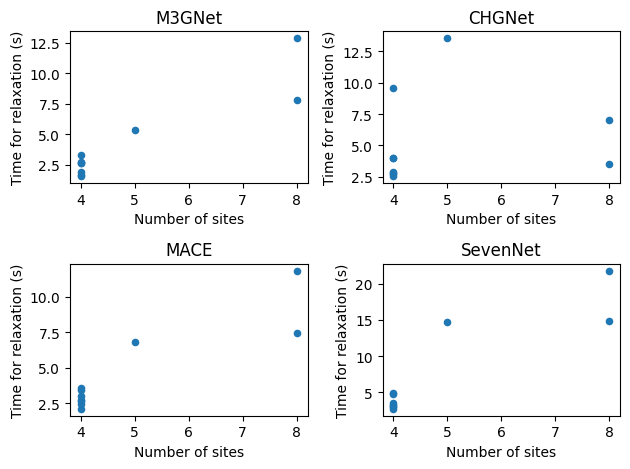

In [8]:
fig, axes = plt.subplots(2, 2)
axes = axes.flatten()
for i, (model_name, model) in enumerate(models):
    ax = axes[i]
    df_preds.plot(x="nsites", y=f"time_total_{model_name}", kind="scatter", ax=ax)
    ax.set_xlabel("Number of sites")
    ax.set_ylabel("Time for relaxation (s)")
    ax.set_title(model_name)

plt.tight_layout()
plt.show()


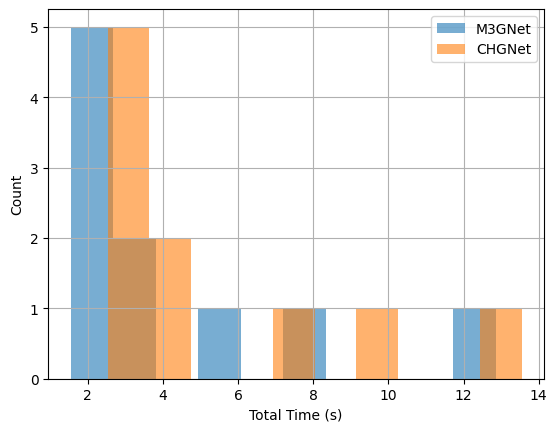

In [9]:
for model_name, _ in models[:2]:
    ax = df_preds[f"time_total_{model_name}"].hist(label=model_name, alpha=0.6)

ax.set_xlabel("Total Time (s)")
ax.set_ylabel("Count")
ax.legend()
plt.show()